In [5]:
import argparse

import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from lateral_connections import LateralModel, VggModel
from lateral_connections import VggWithLCL
from lateral_connections import MNISTCDataset
from lateral_connections.loaders import get_loaders, load_mnistc
from lateral_connections.character_models import SmallVggWithLCL, VGGReconstructionLCL
from lateral_connections.torch_utils import *
from lateral_connections.model_factory import *

import datetime

vggonly_model_path = 'models/vgg_with_lcl/VGG19_2022-04-04_183636__it16250_e3.pt'
vgg19r_lcl5_model_path = 'models/vgg_reconstructed_lcl/2022-04-24_004459_LCL5_d2__it23750_e4.pt'

vgg19r_lcl__fc_only__model_path = 'models/vgg_reconstructed_lcl/2022-05-04_091715_LCL5_d2__it23750_e4.pt'
vgg19r_lcl__random_multiplex_selection__model_path = 'models/vgg_reconstructed_lcl/2022-05-02_131013_LCL5_d2__it17500_e3.pt'
vgg19r_lcl__random_k_change__model_path = 'models/vgg_reconstructed_lcl/2022-05-02_063619_LCL5_d2__it8750_e1.pt'

dataset_identity = load_mnistc(dirname='identity')
dataset_line = load_mnistc(dirname='line')
dataset_gaussian_noise = load_mnistc(dirname='gaussian_noise')

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
def plot_lcl_kernel(model, num_plots=5, plot_scale=2):
    fig, axs = plt.subplots(num_plots, num_plots, figsize=(num_plots*plot_scale, num_plots*plot_scale))

    for x in range(num_plots):
        for y in range(num_plots):
            axs[x,y].imshow(model.features.lcl.K[x, y, ...].cpu().detach().numpy())

    plt.tight_layout()
    plt.show()

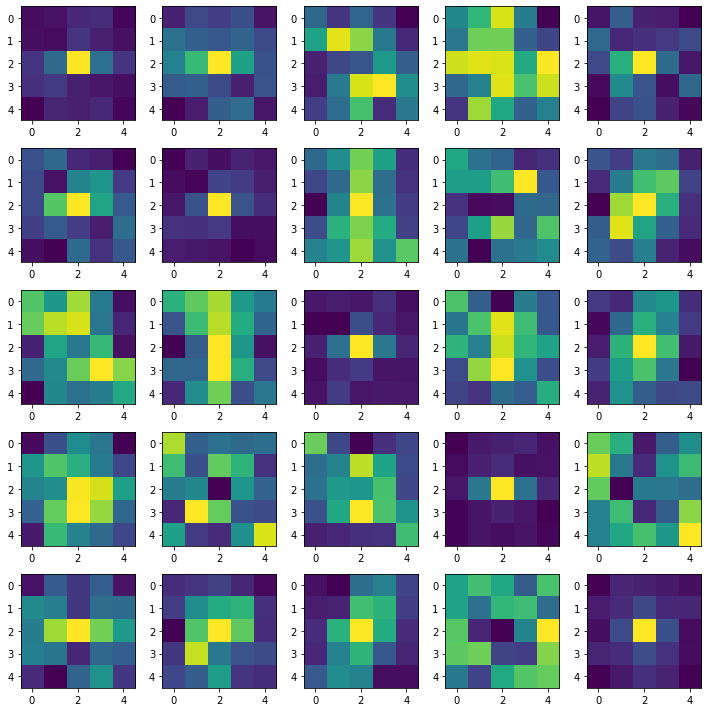

In [9]:
model = load_model_by_key('vgg19r_lcl', vgg19r_lcl5_model_path)
plot_lcl_kernel(vgg19r)
#model

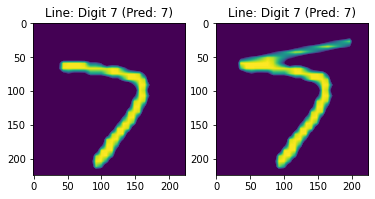

In [93]:
def calculate_L(model, img):
    lcl = model.features.lcl
    
    A = model.features.vgg19_unit(img.unsqueeze(0).to(model.device))
    K = lcl.K

    #A = symmetric_padding(A, lcl.prd).repeat(1, lcl.n, 1, 1).to(model.device)
    A = A.repeat(1, lcl.n, 1, 1).to(model.device)
    padded_A = lcl.pad_activations(A)
    L_unscaled = F.conv2d(padded_A, minmax_on_fm(K.transpose_(0, 1)), padding=0) / lcl.num_fm
    L = softmax_minmax_scaled(L_unscaled)
    
    A_max = torch.sum((1 - lcl.iota) * A + lcl.iota * L, dim=(-2,-1))
    A_max = A_max.reshape((A_max.shape[0], lcl.n, A_max.shape[1] // lcl.n))
    A_max = torch.argmax(torch.transpose(A_max,2,1), dim=-1)

    # Get the argmax indices inside the multiplex cells for each sample in the batch
    fm_indices = A_max.shape[1] * A_max + torch.arange(0, A_max.shape[1]).to(model.device)
    
    A = torch.stack([torch.index_select(i, dim=0, index=j) for i,j in zip(A, fm_indices)])
    
    return L.cpu(), fm_indices.cpu(), A.cpu(), L_unscaled.cpu()

img_index = 17
img, label = dataset_identity[img_index]
img2, label2 = dataset_line[img_index]

fig, axs = plt.subplots(1,2)
axs[0].imshow(img.transpose(1,2).transpose(0,2), vmin=0, vmax=1)
axs[0].set_title(f"Line: Digit {label} (Pred: {torch.argmax(model.forward(img.unsqueeze(0).to(model.device))).data})")
axs[1].imshow(img2.transpose(1,2).transpose(0,2), vmin=0, vmax=1)
axs[1].set_title(f"Line: Digit {label2} (Pred: {torch.argmax(model.forward(img2.unsqueeze(0).to(model.device))).data})")

L, idx, A, Lu = calculate_L(model, img)
L2, idx2, A2, Lu2 = calculate_L(model, img2)

In [108]:
A.min(), A.max(), L.min(), L.max(), Lu.min(), Lu.max()

(tensor(0.),
 tensor(16.3972),
 tensor(0.),
 tensor(1.),
 tensor(2.5404),
 tensor(27.1447))

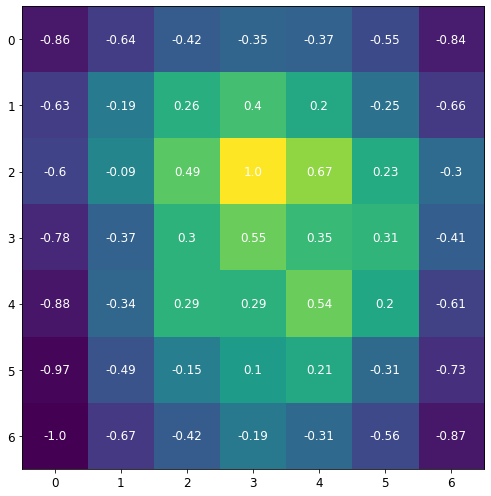

tensor(-1.) tensor(1.)


In [116]:
def show_cm_plot(cm, title=None, figsize=(7,7)):
    fig, ax = plt.subplots(figsize=figsize)
    
    ax.imshow(cm.cpu().detach().numpy())

    ax.set_xticks(np.arange(cm.shape[0]))
    ax.set_yticks(np.arange(cm.shape[1]))
    for x in range(cm.shape[0]):
        for y in range(cm.shape[1]):
            ax.text(y, x, round(cm[x,y].item(),2), ha='center', va='center', color='w', size=12)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    print(cm.min(), cm.max())

#show_cm_plot(torch.sum(A[0], dim=0))
#show_cm_plot(Lu[0,0])
show_cm_plot(2*minmax_on_fm(Lu)[0,0]-1)

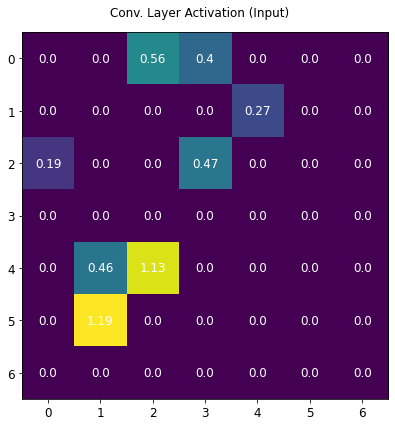

tensor(0.) tensor(1.1923)


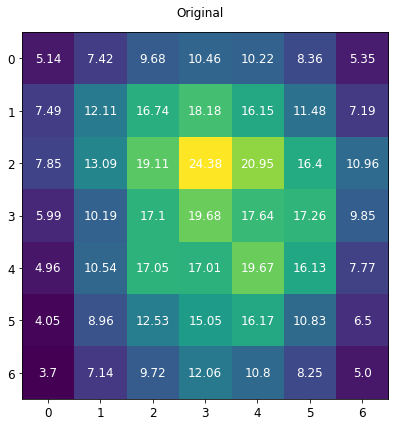

tensor(3.6970) tensor(24.3813)


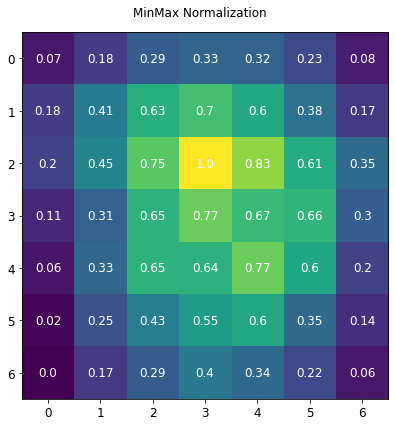

tensor(0.) tensor(1.)


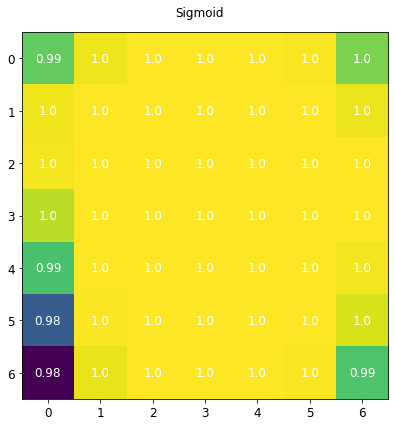

tensor(0.9758) tensor(1.)


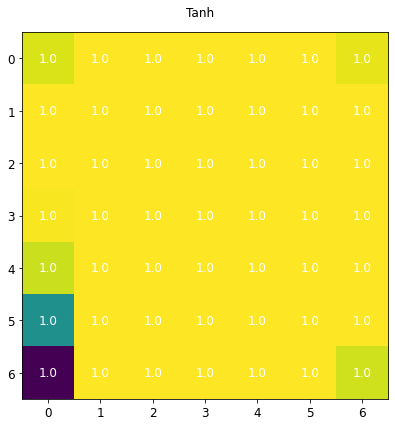

tensor(0.9988) tensor(1.)


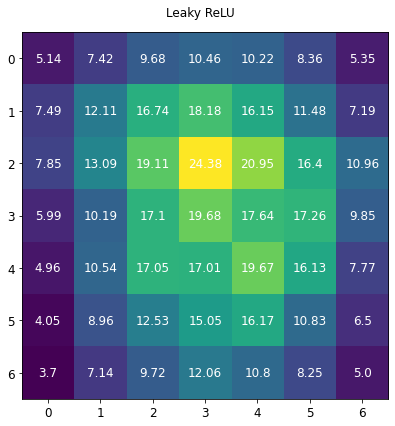

tensor(3.6970) tensor(24.3813)


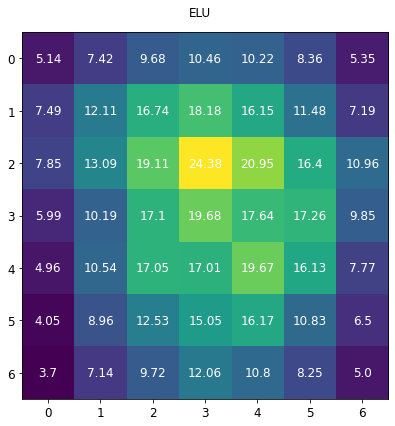

tensor(3.6970) tensor(24.3813)


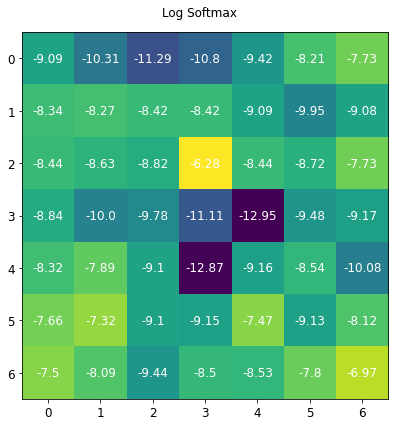

tensor(-12.9488) tensor(-6.2756)


In [120]:
show_cm_plot(A[0,0], 'Conv. Layer Activation (Input)', figsize=(6,6))
show_cm_plot(Lu[0,0], 'Original', figsize=(6,6))
show_cm_plot(minmax_on_fm(Lu)[0,0], 'MinMax Normalization', figsize=(6,6))
show_cm_plot(torch.sigmoid(Lu[0])[0].cpu(), 'Sigmoid', figsize=(6,6))
show_cm_plot(torch.tanh(Lu[0])[0].cpu(), 'Tanh', figsize=(6,6))
show_cm_plot(torch.nn.functional.leaky_relu(Lu[0])[0].cpu(), 'Leaky ReLU', figsize=(6,6))
show_cm_plot(torch.nn.functional.elu(Lu[0])[0].cpu(), 'ELU', figsize=(6,6))
show_cm_plot(torch.nn.functional.log_softmax(Lu[0], dim=0)[0].cpu(), 'Log Softmax', figsize=(6,6))

torch.Size([1, 512, 7, 7])


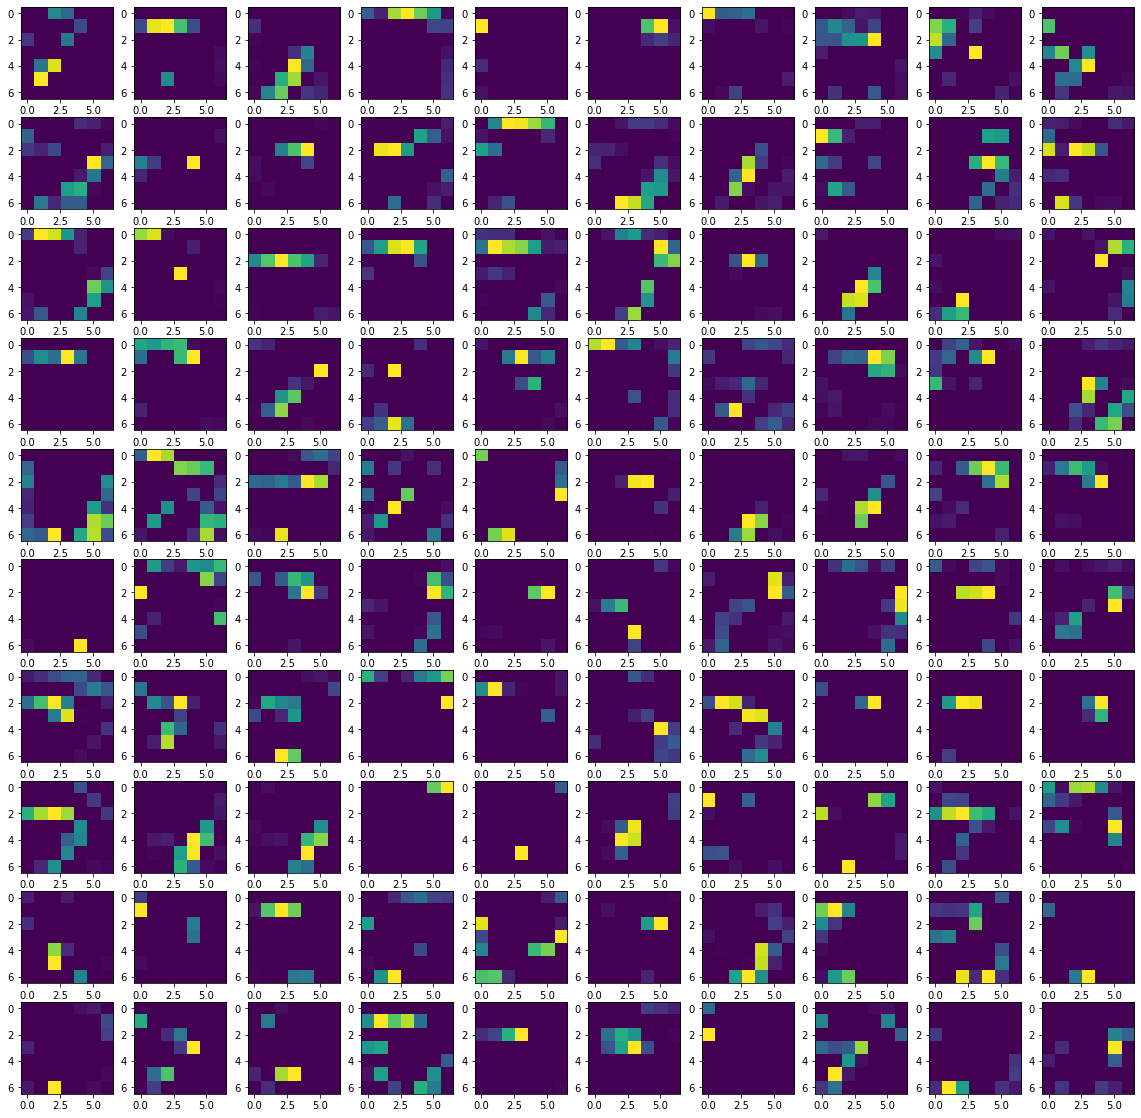

In [63]:
print(A.shape)
fig, axs = plt.subplots(10, 10, figsize=(20,20))

for x in range(10):
    for y in range(10):
        i = x + 10*y
        
        axs[x,y].imshow(A[0,i].cpu())

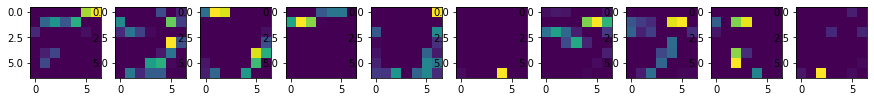

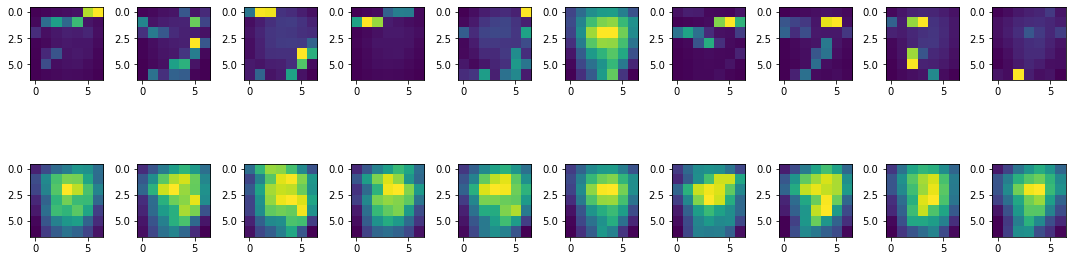

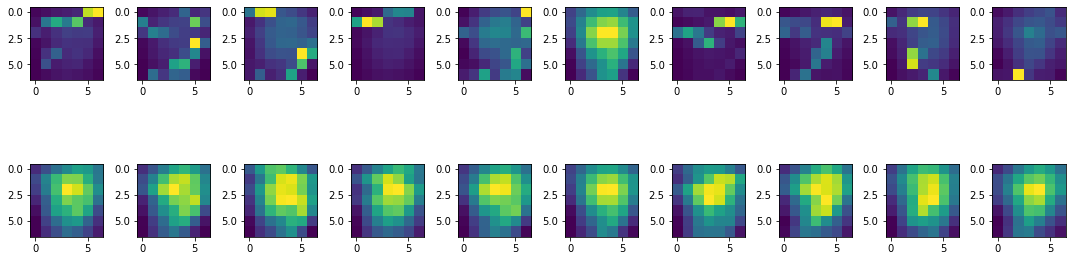

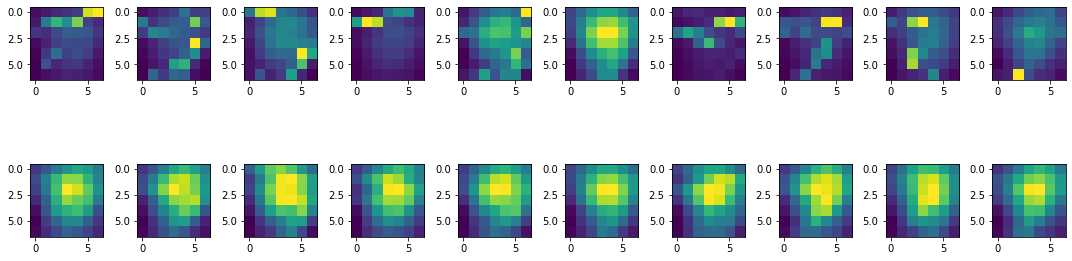

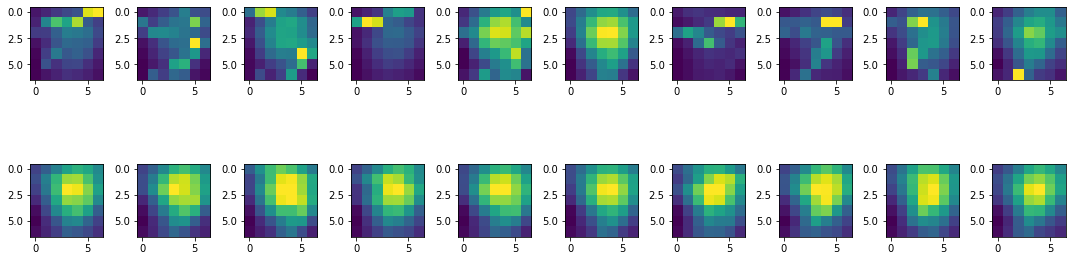

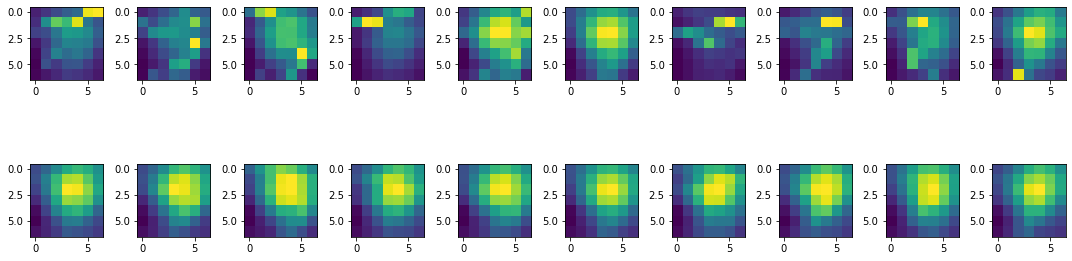

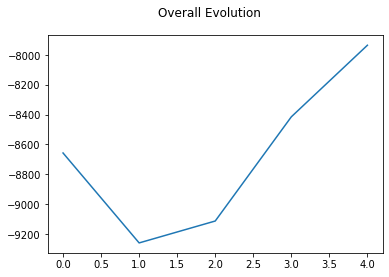

In [91]:
lcl = model.features.lcl

A = model.features.vgg19_unit(img2.unsqueeze(0).to(model.device))
K = lcl.K

data = []

#show_cm_plot(A[0,2])

fig, axs = plt.subplots(1,10, figsize=(15,3))
for i in range(10):
    axs[i].imshow(A[0,i].cpu())
plt.show()


for _ in range(5):
    A = A.repeat(1, lcl.n, 1, 1).to(model.device)
    padded_A = lcl.pad_activations(A)
    L_unscaled = F.conv2d(padded_A, minmax_on_fm(K.transpose_(0, 1)), padding=0) / lcl.num_fm
    #show_cm_plot(minmax_on_fm(L_unscaled)[0,2])
    L = (2*minmax_on_fm(L_unscaled)-1)
    #show_cm_plot(L[0,2])
    data.append(torch.sum(L).cpu())
    
    A_max = torch.sum((1 - lcl.iota) * A + lcl.iota * L, dim=(-2,-1))
    A_max = A_max.reshape((A_max.shape[0], lcl.n, A_max.shape[1] // lcl.n))
    A_max = torch.argmax(torch.transpose(A_max,2,1), dim=-1)

    # Get the argmax indices inside the multiplex cells for each sample in the batch
    fm_indices = A_max.shape[1] * A_max + torch.arange(0, A_max.shape[1]).to(model.device)

    #A = torch.stack([torch.index_select(i, dim=0, index=j) for i,j in zip(A, fm_indices)])
    A = torch.stack([torch.index_select(i, dim=0, index=j) for i,j in zip((1-lcl.iota)*A+(lcl.iota)*L, fm_indices)])
    
    #show_cm_plot(A[0,2])
    
    fig, axs = plt.subplots(2,10, figsize=(15,5))
    for i in range(10):
        axs[0,i].imshow(A[0,i].cpu())
        axs[1,i].imshow(L[0,i].cpu())
    plt.tight_layout()
    plt.show()

plt.plot(data)
plt.suptitle('Overall Evolution')
plt.show()

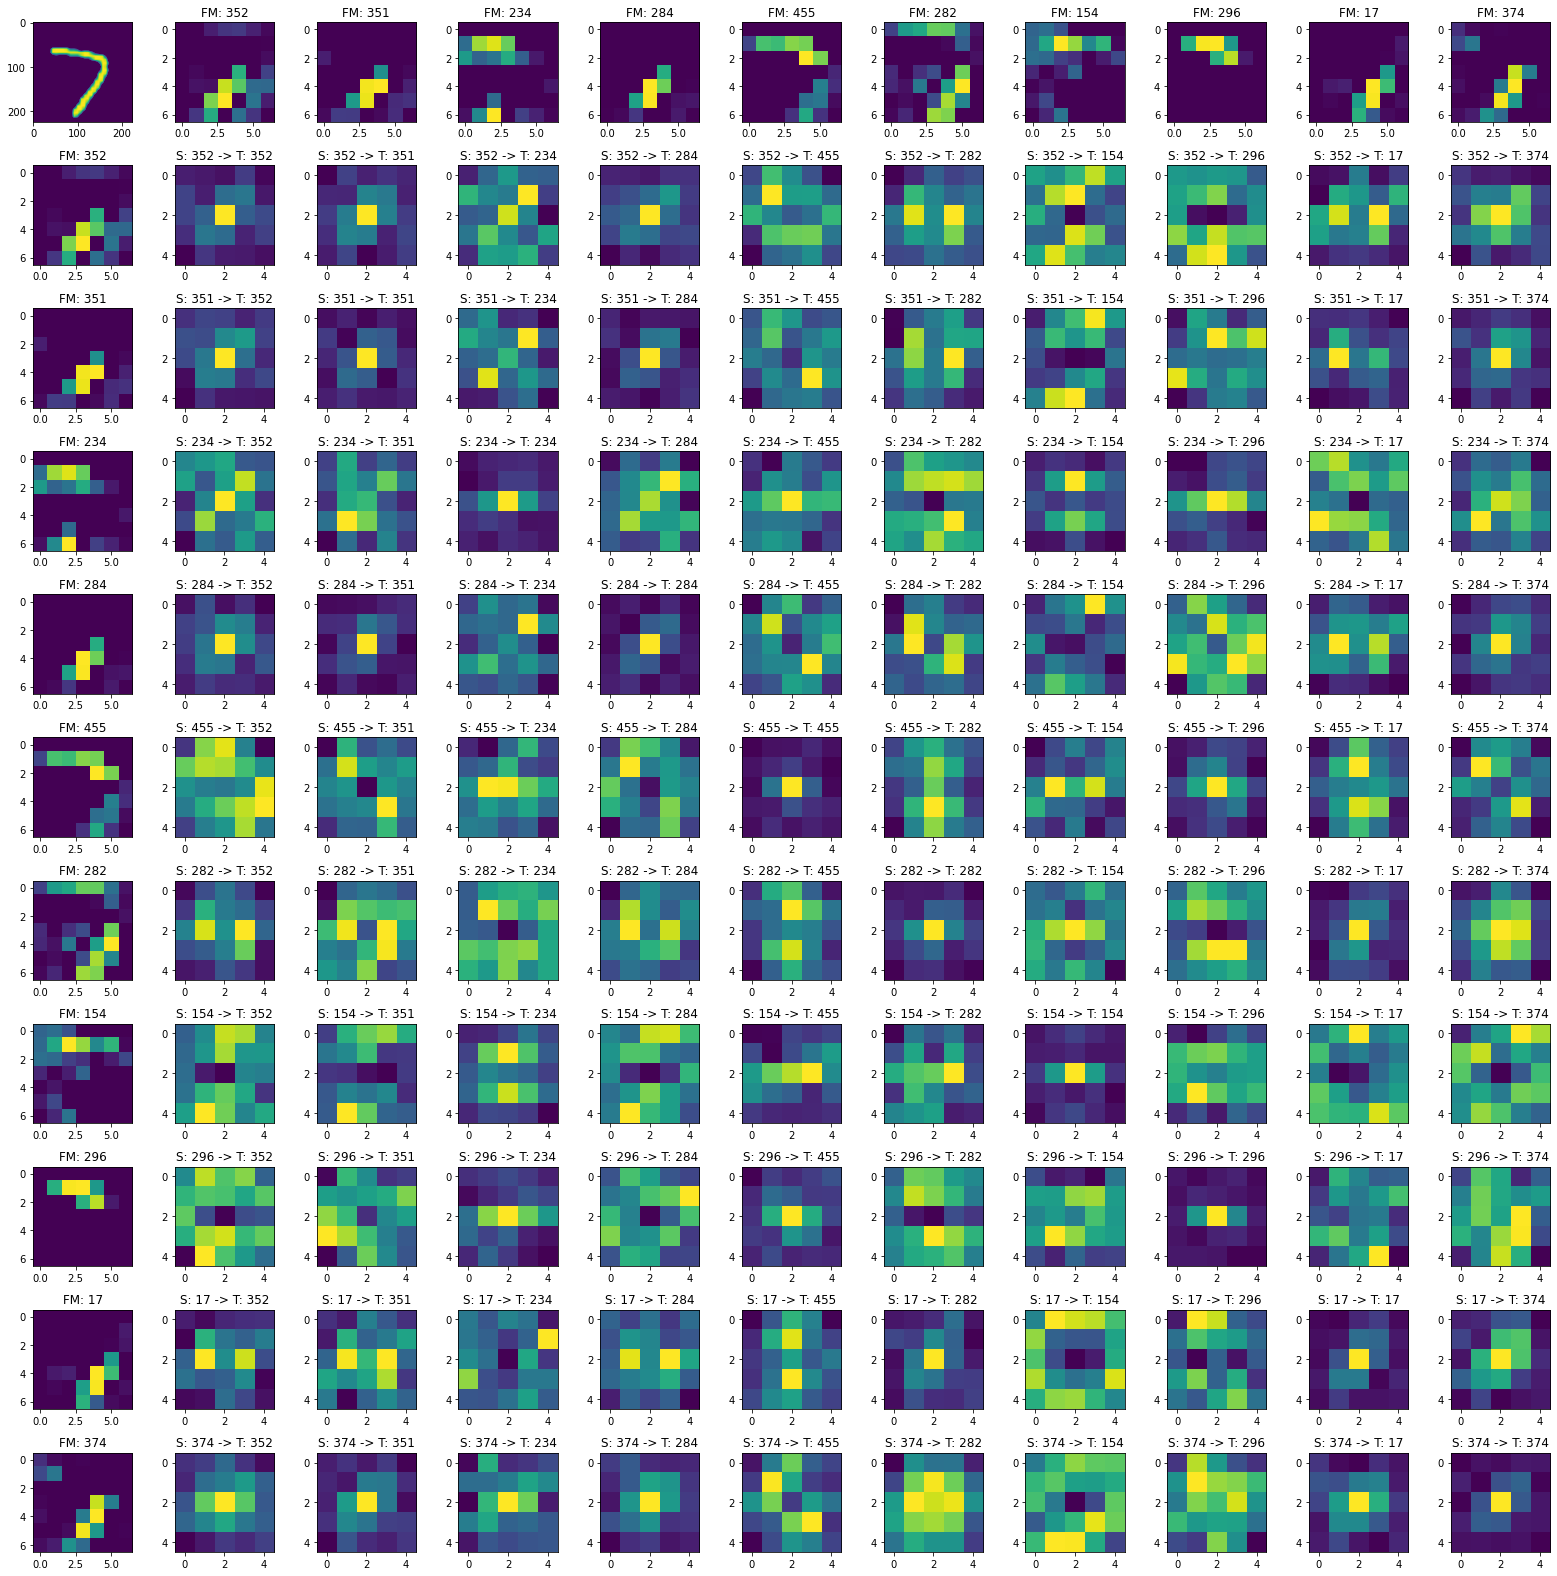

In [6]:
def generate_feature_map_plot(img, topk=10, plot_scale=2):
    L, fm_idx, A = calculate_L(model, img)
    
    # TODO: Change to A once the reconstructed models have been retrained!
    A2 = model.features.vgg19_unit(img.unsqueeze(0).to(model.device))
    A2 = A2.repeat(1, model.features.lcl.n, 1, 1).cpu()
    
    filtered_L = torch.stack([torch.index_select(i, dim=0, index=j) for i,j in zip(L, fm_idx)])
    
    #topk_indices = torch.topk(torch.sum(filtered_L, dim=(-2,-1)), topk).indices[0]
    topk_indices = torch.topk(torch.sum(A, dim=(-2, -1)), topk).indices[0]
    
    fig, axs = plt.subplots(topk+1, topk+1, figsize=((topk+1)*plot_scale, (topk+1)*plot_scale))
    axs[0,0].imshow(img.transpose(1,2).transpose(0,2), vmin=0)
    
    for k in range(topk):
        target_fm = topk_indices[k]
        axs[0, k+1].imshow(A[0, target_fm, ...].cpu(), vmin=0)
        axs[0, k+1].set_title(f"FM: {target_fm}")

        axs[k+1, 0].imshow(A[0, target_fm, ...].cpu(), vmin=0)
        axs[k+1, 0].set_title(f"FM: {target_fm}")

        for i in range(topk):
            source_fm = topk_indices[i]
            axs[i+1, k+1].imshow(model.features.lcl.K[source_fm, target_fm, ...].cpu())
            axs[i+1, k+1].set_title(f"S: {source_fm} -> T: {target_fm}")
                
    plt.tight_layout()
    plt.show()
                
generate_feature_map_plot(img)

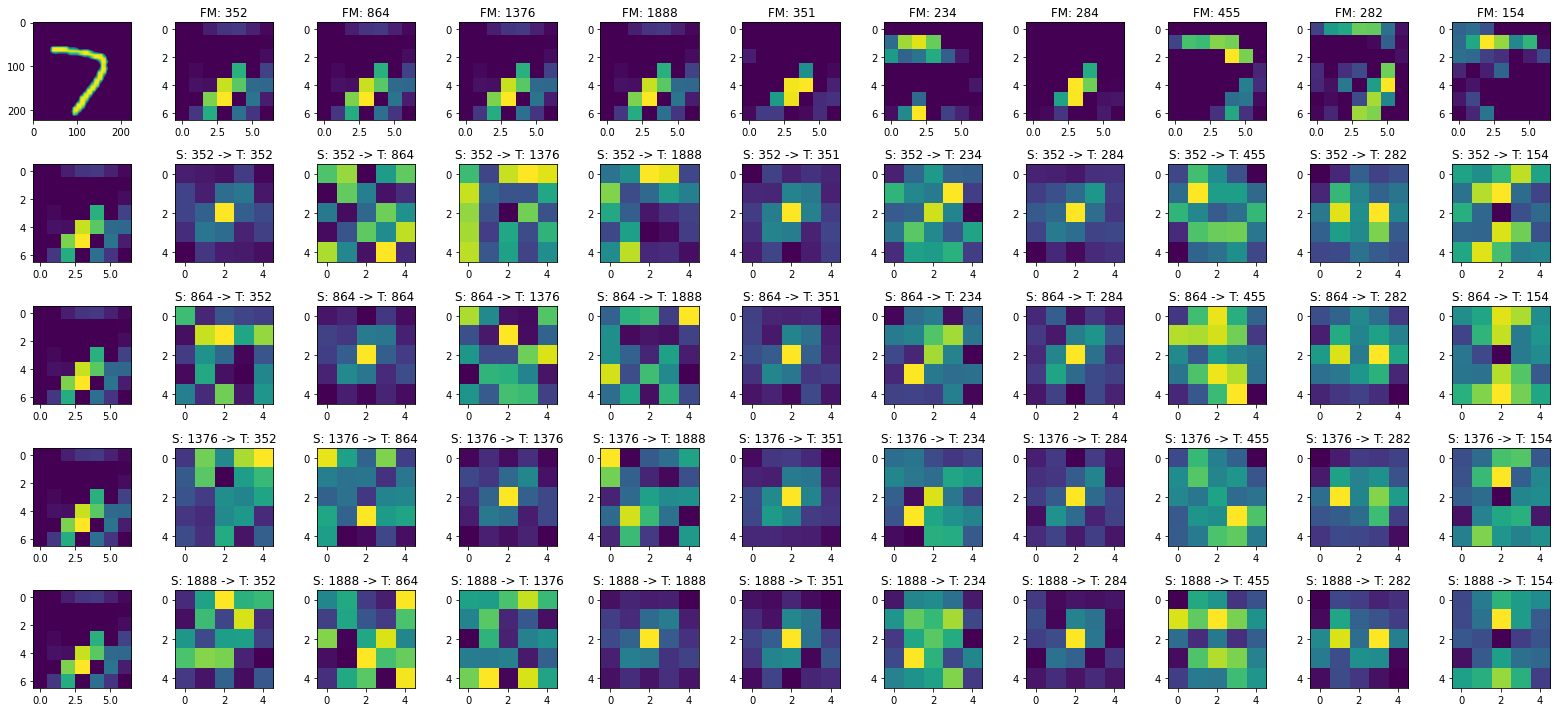

In [44]:
def generate_multiplex_comparison_plot(img, topk=10, plot_scale=2):
    L, fm_idx, A = calculate_L(model, img)
    
    # TODO: Change to A once the reconstructed models have been retrained!
    A2 = model.features.vgg19_unit(img.unsqueeze(0).to(model.device))
    A2 = A2.repeat(1, model.features.lcl.n, 1, 1).cpu()
    
    filtered_L = torch.stack([torch.index_select(i, dim=0, index=j) for i,j in zip(L, fm_idx)])
    
    #topk_indices = torch.topk(torch.sum(filtered_L, dim=(-2,-1)), topk).indices[0]
    topk_indices = torch.topk(torch.sum(A, dim=(-2, -1)), topk).indices[0]
    topk_indices = topk_indices.cpu().numpy()

    # Generate multiplex indices corresponding to the stronges one
    fm_index = topk_indices[0] % 512
    multiplex_indices = (512 * np.arange(4))
    multiplex_indices += fm_index

    # Replace first 4 indices with the multiplex of the strongest one
    topk_indices[-6:] = topk_indices[1:7]
    topk_indices[:4] = multiplex_indices
    
    
    fig, axs = plt.subplots(4+1, topk+1, figsize=((topk+1)*plot_scale, (4+1)*plot_scale))
    axs[0,0].imshow(img.transpose(1,2).transpose(0,2), vmin=0)
    
    for k in range(topk):
        target_fm = topk_indices[k]
        axs[0, k+1].imshow(A2[0, target_fm, ...].cpu(), vmin=0)
        axs[0, k+1].set_title(f"FM: {target_fm}")
        
        for i in range(4):
            source_fm = multiplex_indices[i]
            axs[i+1, 0].imshow(A2[0, source_fm, ...].cpu(), vmin=0)
        
            axs[i+1, k+1].imshow(model.features.lcl.K[source_fm, target_fm, ...].cpu())
            axs[i+1, k+1].set_title(f"S: {source_fm} -> T: {target_fm}")
    
    
        """
        axs[k+1, 0].imshow(A[0, target_fm, ...].cpu(), vmin=0)
        axs[k+1, 0].set_title(f"FM: {target_fm}")

        for i in range(topk):
            source_fm = topk_indices[i]
            axs[i+1, k+1].imshow(model.features.lcl.K[source_fm, target_fm, ...].cpu())
            axs[i+1, k+1].set_title(f"S: {source_fm} -> T: {target_fm}")
        """
           
    plt.tight_layout()
    plt.show()
                
generate_multiplex_comparison_plot(img)